<a href="https://colab.research.google.com/github/AleemRahil/Robust-End-to-End-E-Commerce-Analytics-Automation-with-LLMs/blob/main/ecommerce_product_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shopify Product Discovery With OpenAI Retrieval

In this project we'll dive into embedding Ecommerce product data, utilizing vector similarity search with Scikit Learn for precise product matching, and doing product retrieval with OpenAI assistants

Ecommerce product discovery is about understanding customer purchase intent. Combining signals from product data, order data, and web data to correctly understand customer needs, and customer desires and match them with the right products is key to reducing buyer friction and increasing conversion rates.

In this notebook, we will do basic product discovery with OpenAI by utilizing vector similarity search. Specifically, we'll dive into the mechanics of product embeddings, and explore the latest OpenAI embeddings.

I'll also guide you through how to embed Ecommerce product data and then utilize vector similarity search with Scikit Learn for product matching, and retrieval. Plus, we'll use the same data to have a look at how OpenAI Assistant retrieval works and do simple product discovery in the OpenAI Playground.

What we'll cover:

Embeddings Explained: What are embeddings and why are they relevant for ecommerce?

Embedding Ecommerce Product Data: We'll take a look at how to use OpenAI's latest embedding models for creating product embeddings.

Vector Similarity Search with Scikit Learn: Using Scikit Learn for effective product matching based on vector similarity.

Assistant Product Retrieval: Leveraging AI assistants for product retrieval and customer service.

Product Discovery in the OpenAI Playground: How to experiment with product discovery using the OpenAI Playground.

#Product Embeddings Explained
Embeddings are learned representations of text. They are sequences of numbers that capture the essence of content, whether text or code. These numerical sequences help machine learning models and other algorithms grasp how pieces of content are related, which is critical for grouping similar items (clustering) or finding specific items (retrieval).

Embeddings are the driving force behind features like knowledge retrieval in ChatGPT, the Assistants API, and various tools for retrieval-augmented generation (RAG).

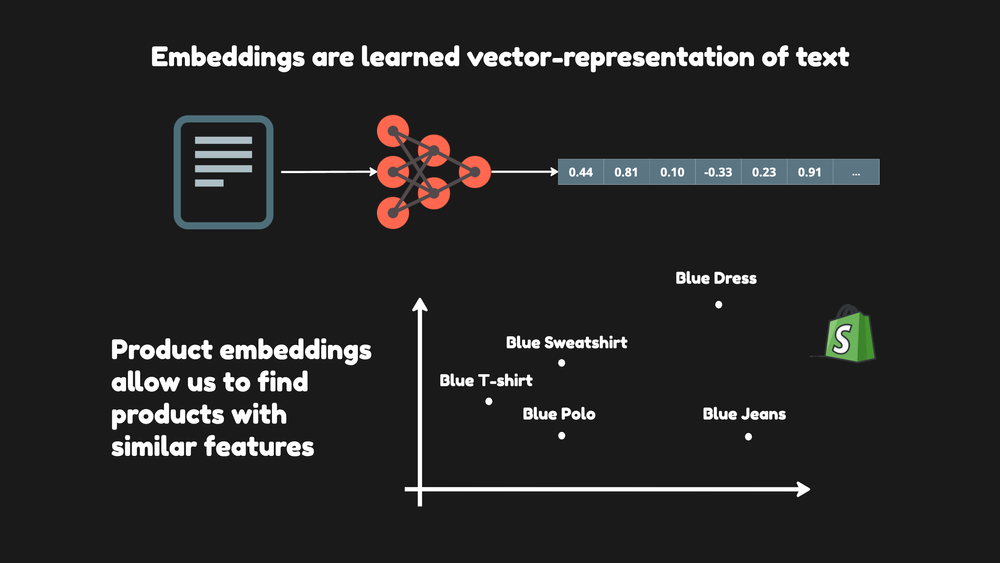

Product embeddings allow us to map products to a numerical space. In this space, each product is positioned so that similar products are located near each other and dissimilar ones are placed further apart.

The specific location of a product in this space is known as its product vector. The embedding process is valuable for personalization models, enabling the discovery of nuanced information about products and tailoring search results to individual preferences.

Setup & Product Data
To begin setting up your environment for working with product data and OpenAI's API, you must install several Python libraries. These libraries include python-dotenv for managing environment variables, openai for accessing OpenAI's API and Hugging Face datasets for downloading the product data.

Here's the command you would run in your Python environment to install these libraries:

In [ ]:
!pip install -qU \
  python-dotenv \
  openai \
  tiktoken \
  datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00


Once you run this command, it will download and install the latest versions of these packages quietly (without showing any output due to the -q flag) and upgrade them if they're already installed (the -U flag).

Next, we'll download the product data that we'll be working with. The datasets library from Hugging Face provides a convenient way to load datasets. I'll use it to load a dataset of fashion product images.

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from datasets import load_dataset

data = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Once the dataset is loaded, data will be a dataset object that you can use to inspect, manipulate, and visualize the product data. We can now explore the dataset by checking its size and structure and by displaying some of the product images and their corresponding labels.

Following the setup, I load the product data into a manageable format for analysis. The process is straightforward, utilizing the Hugging Face datasets library to access a specific dataset focused on fashion product images.

In [ ]:
images = data["image"]
data=data.remove_columns("image")

df=data.to_pandas()

This code effectively separates the images from the textual descriptions within the dataset. The images are stored separately for visual analysis, while the textual data is converted to a Pandas DataFrame. Here's what the dataframe looks like:

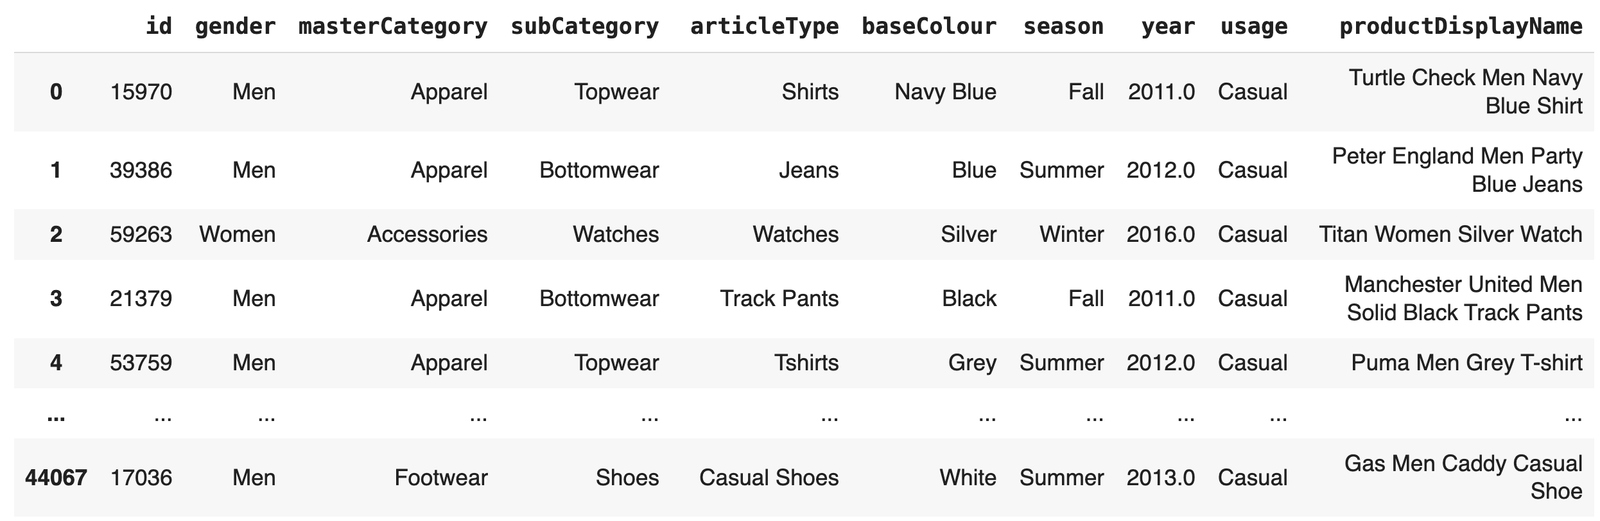

We can now feed the product descriptions into OpenAI's embedding model, generating outputs suitable for semantic search purposes.

In [ ]:
from openai import OpenAI
client = OpenAI()

#Using OpenAI's Text-Embedding-03
By leveraging OpenAI's API, we can convert textual product descriptions into embeddings that can be fed to LLMs. This transformation is key to developing more sophisticated search features that can understand the nuances of product descriptions, facilitating a search experience that recognizes context and content.

You can also use free embeddings from Hugging Face to achieve something similar. Check out this YouTube video for an approach that also works for images:

## OpenAI Embeddings

Here's how you can use OpenAI's API to generate embeddings from product descriptions:

In [ ]:
# Get embeddings for a given text
def get_embeddings(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small", # Choose the appropriate model
        dimensions=1024 # You can shorten the embedding (<1536) without loosing the representational meaning
    )
    return response.data[0].embedding

In [ ]:
embeddings = get_embeddings("Turtle Check Men Navy Blue Shirt")

In [ ]:
# Choose whatever slice of the dataframe you want to use

df=df.head(100).copy()
df['embeddings'] = df['productDisplayName'].apply(get_embeddings)

Here I instantiate the OpenAI client and define a function, get_embeddings, which sends the input text to OpenAI's embeddings API using a specified model. The model chosen is "text-embedding-3-small", which is designed to generate embeddings with a dimensionality of 1024. This specific dimensionality represents a compressed version of the text's information, ensuring a balance between retaining essential features and reducing size.

With the product descriptions converted into embeddings, I then create a function that identifies similar products by using cosine similarity. Cosine similarity measures the cosine of the angle between two vectors, which, in our context, are the embeddings of product descriptions. This determines how similar two product descriptions are, with a higher cosine similarity score indicating greater similarity.

In [ ]:
# Use cosine similarity to create a function that looks for similar products

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to compute cosine similarity
def find_similar_products(query_embedding, embeddings):
    # Convert embeddings list to a numpy array for cosine similarity calculation
    embeddings_matrix = np.array(embeddings.tolist())
    query_embedding = np.array(query_embedding).reshape(1, -1)

    # Compute cosine similarities
    similarities = cosine_similarity(query_embedding, embeddings_matrix)

    # Find the index of the highest similarity
    most_similar_index = similarities.argmax()

    return most_similar_index

The find_similar_products function calculates the cosine similarity between the query embedding and each product embedding in the dataset. It then identifies the product with the highest similarity to the query, effectively finding the most similar product based on the numerical representation of their descriptions.

To search for products with similar descriptions, we first prepare a subset of our product data and obtain embeddings for each description. Following that, we can perform a semantic product search by comparing the embeddings of a query product with those in our dataset to find the most similar product. Here's how you can do it:

Limit the DataFrame to the first 100 entries for efficiency and copy it to avoid any warnings or errors related to modifying the original DataFrame.

Generate embeddings for each product in the DataFrame using the get_embeddings function previously defined.

Define a query product name and obtain its embedding.

Use the find_similar_products function to identify the product index with the closest embedding to the query.

Retrieve the most similar product from the DataFrame and display its name.

In [ ]:
# Do semantic product search

query_product_name = "Navy Blue T-Shirt"
query_embedding = get_embeddings(query_product_name)


most_similar_index = find_similar_products(query_embedding, df['embeddings'])
similar_product = df.iloc[most_similar_index]

print(f"The most similar product to '{query_product_name}' is: {similar_product['productDisplayName']}")

This approach allows us to efficiently find products with descriptions that are semantically similar to a given query, enhancing the shopping experience by providing relevant recommendations.

## Product Discovery with OpenAI Assistants

The OpenAI Assistant API offers a streamlined approach to building Retrieval-Augmented Generation (RAG) chatbots, with the complexity of the retrieval process conveniently abstracted away. This abstraction means developers no longer need to think about vector storage or craft their vector similarity search (VSS) queries. Essentially, the Assistant API handles the heavy lifting, allowing you to focus on designing and refining the conversational aspects of your chatbot without getting bogged down by the underlying technical details. This facilitates a simpler and more efficient development process for creating chatbots that can access a broad range of information and provide more accurate, contextually relevant responses.

To begin leveraging the OpenAI Assistant API for product retrieval, we'll first prepare a file with a dataset of products. This file will be used by the retrieval system, allowing the Assistant to access product information and facilitate meaningful interactions based on product queries.

In [ ]:
df.head(100).to_json('products_small.json')

The file products_small.json can then be uploaded to OpenAI and used with the OpenAI Assistant API to facilitate product retrieval tasks. After preparing your products_small.json file with the selected product data, the next step is to upload it to OpenAI. This is done via the OpenAI client, specifically using the files.create method.

In [ ]:
file = client.files.create(
  file=open("products_small.json", "rb"),
  purpose='assistants'
)

I'm uploading the products_small.json file under the purpose category of 'assistants'. Following the file upload, the next steps are to create a thread and then set up an assistant with retrieval capabilities, leveraging the uploaded product data.

**Create a Thread**: First, we initiate a thread using the OpenAI client. This thread is a container for your interactions, enabling structured and trackable conversations with the assistant.

In [ ]:
thread = client.beta.threads.create()
print(thread.id)

Executing this code generates a new thread and prints its ID, which you'll use to manage and reference the ongoing conversation within your application.

**Instantiate an Assistant with Retrieval Capabilities**: Next, we create an assistant designed specifically for product discovery. This assistant is configured to draw on the knowledge base provided in your uploaded file, focusing on delivering precise product recommendations without referencing the file directly or offering generic advice:

In [ ]:
prompt="""You are an ecommerce sales chatbot.
Use your knowledge base given in the file to help the customers with product discovery.
Don't offer general guidance, get info from the file but don't mention the file."""

assistant = client.beta.assistants.create(
  instructions=prompt,
  model="gpt-4-0125-preview",
  name="Product Discovery Assistant",
  tools=[{"type": "retrieval"}],
  file_ids=[file.id]
)

This step creates an assistant named "Product Discovery Assistant" with instructions that define its behavior and objectives. By specifying tools=[{"type": "retrieval"}] and file_ids=[file.id], you're equipping the assistant with the ability to perform content-based retrieval from the uploaded product data, enabling informed interactions tailored to user queries about products.

To engage the assistant for product discovery, you'll first send a customer message to the thread you've created and then prompt the assistant to process this message to provide relevant product recommendations.

**Send a Customer Message**: Let's create a message within the thread that simulates a customer inquiry, such as a customer looking for a "nice blue men's shirt."

In [ ]:
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="I'm looking for a nice blue men's shirt"
)

Now the message has been attached to the thread, and we can proceed to run the assistant on the thread.

**Run the Assistant**: With the customer's message in place, we initiate a run, instructing the assistant to process the inquiry based on the parameters and capabilities we defined earlier and using the uploaded file for data retrieval.

In [ ]:
instructions="""Please answer questions as simple as possible using provided data in the uploaded file."""

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions=instructions
)

This command triggers the assistant to analyze the customer's request and generate a response by pulling relevant information from the product data.

**Fetch the Messages**: After the assistant processes the customer's query, we can retrieve the conversation's messages to see the assistant's recommendations.

In [ ]:
# You can check the status of the run with runs.retrieve

run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

print(run.status)

This final step allows you to review the assistant's response to the customer's inquiry, which is based on retrieving specific product information from the uploaded file.

#Hitting The OpenAI Playground
Now, let's try out the assistant in the OpenAI Playground. If you go to https://platform.openai.com/assistants you will get an overview of the assistants you have created either by using the API or directly in the playground.

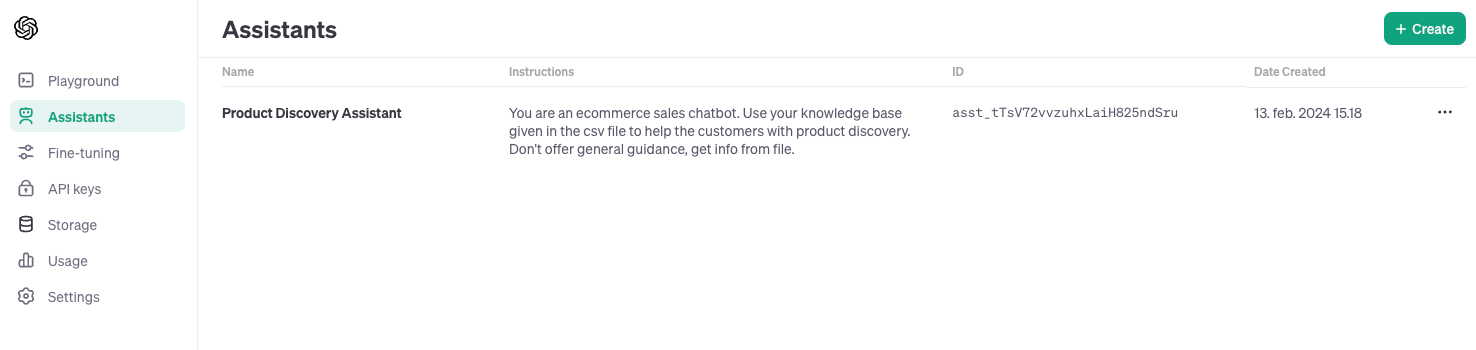

If we click on the assistant, we can adjust the configuration or take it for a test drive using the graphical user interface.

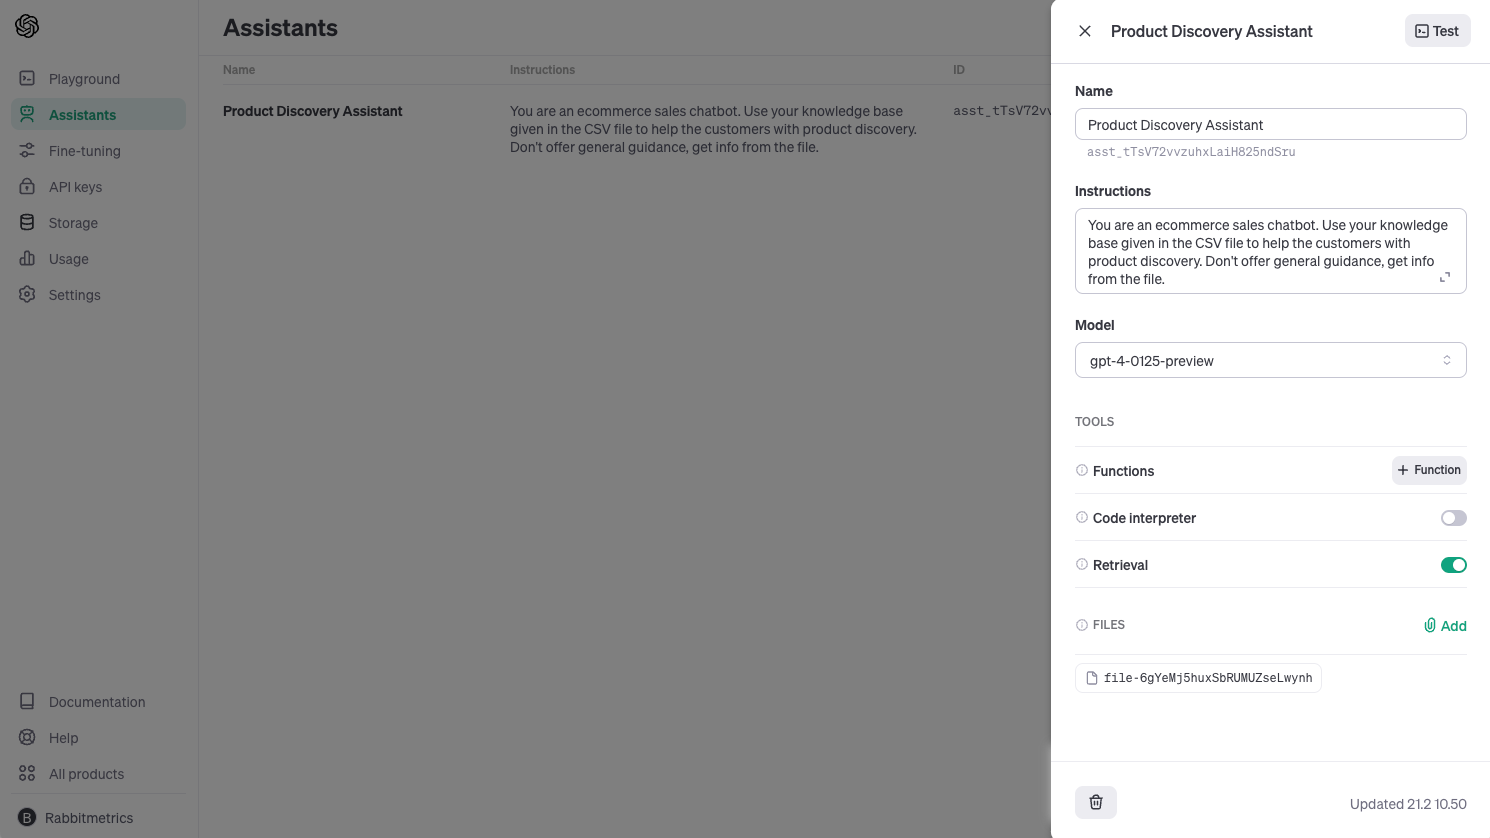

We do that by creating a thread, entering a message, and then running the thread - exactly like we did in the notebook.

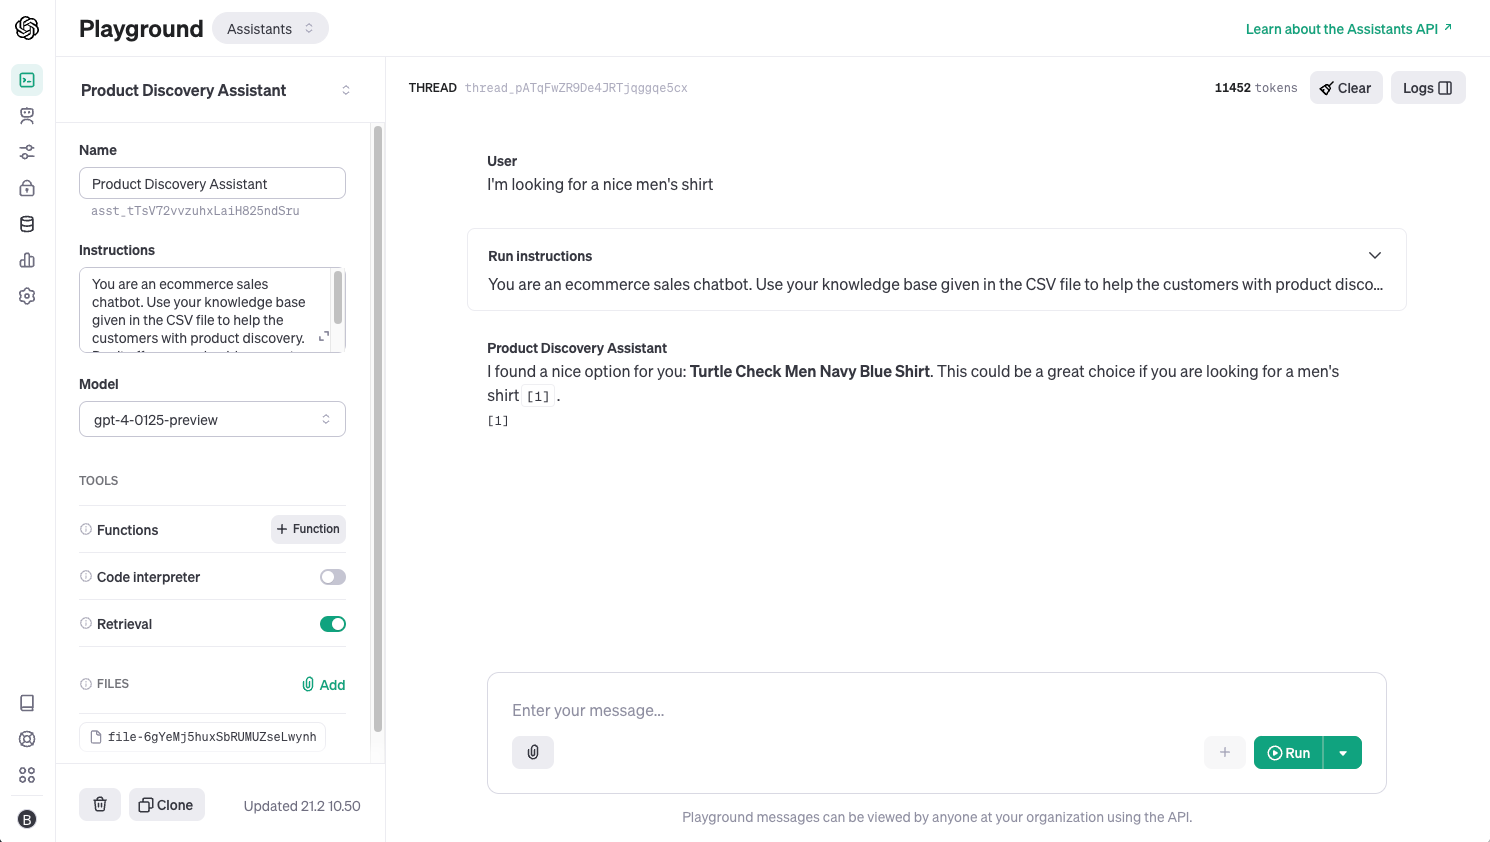

In [ ]:
from datetime import datetime

# This function will display the messages from the conversation properly

def print_conversation(messages_object):
    # Sort messages by their creation time
    sorted_messages = sorted(messages_object.data, key=lambda x: x.created_at)

    # Iterate through the sorted messages and print them
    for msg in sorted_messages:
        # Convert timestamp to readable format
        timestamp = datetime.utcfromtimestamp(msg.created_at).strftime('%Y-%m-%d %H:%M:%S')
        role = "Assistant" if msg.role == 'assistant' else "User"
        text = msg.content[0].text.value if msg.content else "No text content"
        print(f"{timestamp} [{role}]: {text}")

In [ ]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print_conversation(messages)

The playground allows you to interact with the RAG Assistant directly without writing any code, and you can even configure the assistant directly from the playground.